In [1]:
#%matplotlib notebook
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, desc

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

,precipitation
date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,0.02
2016-08-23,1.79


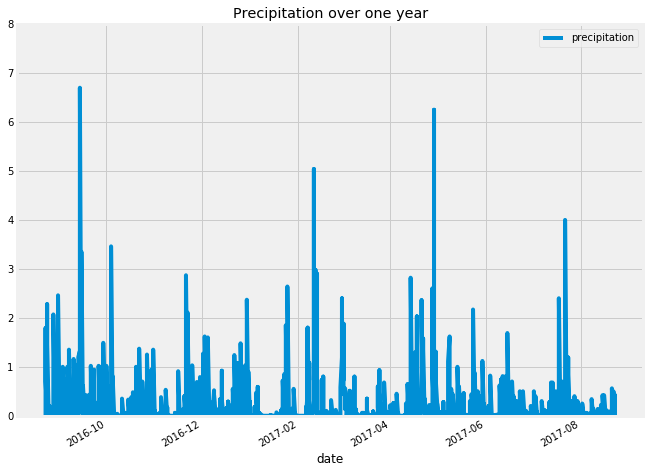

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date one year from the last date in data set
last_date, = session.query(Measurement.date).order_by(desc(Measurement.id)).first()

year_ago_date = dt.datetime.strptime(last_date, '%Y-%m-%d') - dt.timedelta(days=365)
year_ago_date = year_ago_date.strftime('%Y-%m-%d')

# Perform a query to retrieve the data and precipitation scores
# Sort by date
one_year_prcp_data_query = session.query(
                            Measurement.date,
                            Measurement.prcp.label('precipitation')
                        ).filter(
                            Measurement.date >= year_ago_date,
                            Measurement.date <= last_date,
                            Measurement.prcp.isnot(None)
                        ).order_by(
                            Measurement.date
                        )

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.read_sql_query(one_year_prcp_data_query.statement,
                            one_year_prcp_data_query.session.bind,
                            index_col='date')

prcp_df.index = pd.to_datetime(prcp_df.index)

# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot(title="Precipitation over one year", figsize=(10,8))

# Rotate the xticks for the dates
plt.ylim(0, 8)

# Show the dataframe
prcp_df.head()

In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [12]:
# How many stations are available in this dataset?
total_station = session.query(Station).count()
print(f'Total number of station: {total_station}')

Total number of station: 9


In [13]:
# What are the most active stations?
# List the stations and the counts in descending order.
station_count = session.query(
                    Measurement.station,
                    func.count(Measurement.station)
                ).group_by(
                    Measurement.station
                ).order_by(
                    desc(func.count(Measurement.station))
                ).all()

station_count

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
most_active_station_stats = session.query(
                                func.min(Measurement.tobs),
                                func.max(Measurement.tobs),
                                func.avg(Measurement.tobs)
                            ).filter(
                                Measurement.station == 'USC00519281'
                            ).group_by(
                                Measurement.station
                            ).all()
most_active_station_stats

[(54.0, 85.0, 71.66378066378067)]

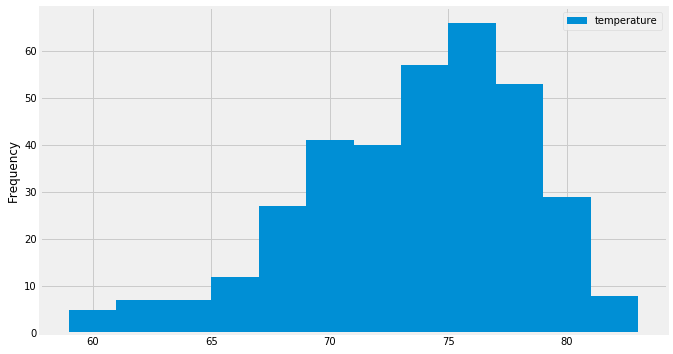

In [15]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_station_temp_data_query = session.query(
                                            Measurement.date,
                                            Measurement.tobs.label('temperature')
                                      ).filter(
                                            Measurement.date >= year_ago_date,
                                            Measurement.date <= last_date,
                                            Measurement.station == 'USC00519281',
                                            Measurement.tobs.isnot(None)
                                      ).order_by(
                                            desc(Measurement.date)
                                      )

temperature_df = pd.read_sql_query(most_active_station_temp_data_query.statement, session.bind)
temperature_df.plot.hist(bins=12, label='tobs', figsize=(10,6))

In [16]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [17]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
temp_stats = calc_temps('2017-06-01', '2017-06-10')
tmin, tavg, tmax = temp_stats[0]
print(f'Minimum Temp = {tmin}, Average Temp = {tavg}, Maximum Temp = {tmax}')

Minimum Temp = 72.0, Average Temp = 77.546875, Maximum Temp = 81.0


(2.8, 3.2)

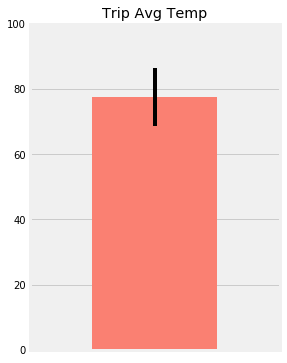

In [18]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.figure(figsize=(4,6))
plt.bar(x=[3], height=[tavg], width=0.2, yerr=tmax-tmin, color='salmon')
plt.title('Trip Avg Temp')
plt.yticks([0,20,40,60,80,100])
plt.xticks([])
plt.xlim(2.8, 3.2)

In [19]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
rainfall_by_station = session.query(
                        Station.station,
                        Station.name,
                        Station.latitude,
                        Station.longitude,
                        Station.elevation,
                        func.max(Measurement.prcp)
                    ).join(
                        Measurement,
                        Station.station == Measurement.station
                    ).filter(
                        Measurement.date >= '2017-06-01',
                        Measurement.date <= '2017-06-10',
                    ).group_by(
                        Measurement.station
                    ).order_by(
                        desc(func.max(Measurement.prcp))
                    ).all()

rainfall_by_station

[('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  0.82),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  0.62),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  0.53),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.21),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  0.15),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.04),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, None)]

## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
daily_normals("06-01")

# push each tuple of calculations into a list called `normals`
normals= []

# Set the start and end date of the trip
trip_start_date = '2019-06-01'
trip_end_date = '2019-06-10'

# Use the start and end date to create a range of dates
date_list = [dt.datetime.strptime(trip_start_date, '%Y-%m-%d') + dt.timedelta(days=x) for x in range(0, 10)]

# Loop through the list of %m-%d strings and calculate the normals for each date
for each_date in date_list:
    each_day = each_date.strftime('%m-%d')
    normals.append(daily_normals(each_day)[0])

normals

[(64.0, 74.6140350877193, 81.0),
 (65.0, 74.4, 81.0),
 (65.0, 74.03448275862068, 80.0),
 (65.0, 73.81818181818181, 81.0),
 (68.0, 74.85454545454546, 81.0),
 (70.0, 75.17543859649123, 80.0),
 (68.0, 75.07142857142857, 81.0),
 (70.0, 75.58620689655173, 81.0),
 (69.0, 75.15254237288136, 81.0),
 (68.0, 75.14285714285714, 81.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
daily_normals_df = pd.DataFrame(normals, columns=['tmin', 'tavg', 'tmax'])
daily_normals_df['date'] = date_list
daily_normals_df.set_index('date', inplace=True)
daily_normals_df.index = pd.to_datetime(daily_normals_df.index)
daily_normals_df

,tmin,tavg,tmax
date,,,
2019-06-01,64.0,74.614035,81.0
2019-06-02,65.0,74.400000,81.0
2019-06-03,65.0,74.034483,80.0
2019-06-04,65.0,73.818182,81.0
2019-06-05,68.0,74.854545,81.0
2019-06-06,70.0,75.175439,80.0
2019-06-07,68.0,75.071429,81.0
2019-06-08,70.0,75.586207,81.0
2019-06-09,69.0,75.152542,81.0


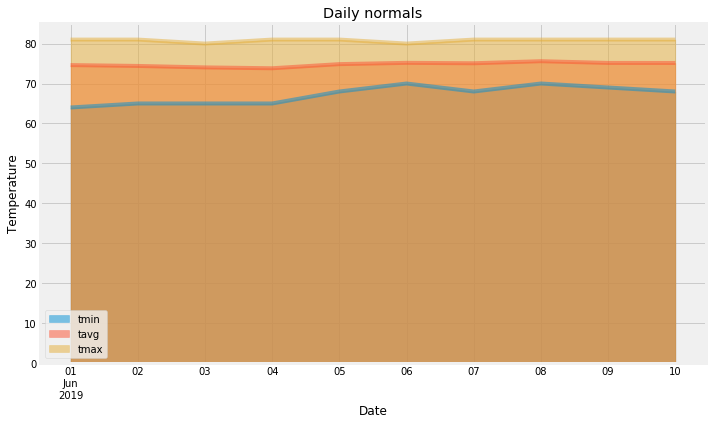

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
daily_normals_df.plot.area(xticks=daily_normals_df.index, stacked=False, figsize=(10,6))
plt.title('Daily normals')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.tight_layout()
